# Usage example for the `multinull_jsd` package

In this notebook, we show how to use `multinull_jsd.MultiNullJSDTest` class to compare several candidate discrete probability models against an observed histogram.


## Experimental Scenario

Imagine a survey question with three possible answers:

1. **Support**.
2. **Neutral**.
3. **Oppose**.

Then, you collect $n = 100$ responses and obtain the following counts:

- 55 people chose **Support**.
- 22 people chose **Neutral**.
- 23 people chose **Oppose**.

We can write the observed counts as a histogram $\mathbf{h}$ such that
$$\mathbf{h} = (h_1, h_2, h_3) = (55, 22, 23).$$

You also have two candidate models (null hypotheses) for how people *should* respond,
if your theory is correct:

- $\mathcal{H}_0^1$ (Null baseline model): $\mathbf{p}_1 = (0.50, 0.30, 0.20)$,
- $\mathcal{H}_0^2$ (Null modified model): $\mathbf{p}_2 = (0.40, 0.40, 0.20)$,

or equivalently:

- $\mathcal{H}_0^1$: $50\%$ support, $30\%$ neutral, and $20\%$ oppose,
- $\mathcal{H}_0^2$: $40\%$ support, $40\%$ neutral, and $20\%$ oppose.

Each null hypothesis comes with a desired significance level (Type I error):

- $\mathcal{H}_0^1$'s desired significance level: $\alpha_1 = 0.05$,
- $\mathcal{H}_0^2$'s desired significance level: $\alpha_2 = 0.01$.

In words, we are asking:

> *Which of these probability models is best supported by the observed histogram?*
>
> Or, alternatively, *should we reject all of them in favor of a generic alternative hypothesis ($\mathcal{H}_1$), which means that "none of the proposed models fits well"?*


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt

from multinull_jsd import MultiNullJSDTest

## 1. Observed data: histogram and visualization

We encode the observed counts as a list of integers. We also compute:

- `evidence_size` $= \sum_{i=1}^3 h_i$: total number of observations,
- `prob_dim` $= k$: number of categories.


In [2]:
observed_counts = [55, 22, 23]
categories = ["Support", "Neutral", "Oppose"]

evidence_size = sum(observed_counts)  # Total number of observations
prob_dim = len(observed_counts)       # Number of categories

print("Observed histogram (counts per category):")
for cat, count in zip(categories, observed_counts):
    print(f"  {cat:7s}: {count:3d}")
print(f"Total responses (evidence_size): {evidence_size}")

Observed histogram (counts per category):
  Support:  55
  Neutral:  22
  Oppose :  23
Total responses (evidence_size): 100


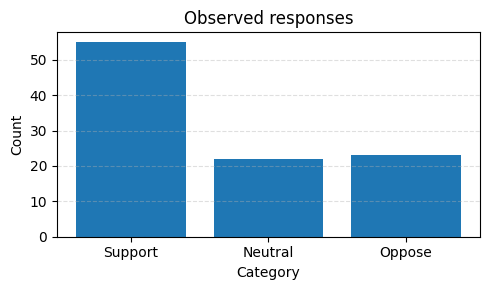

In [3]:
# Visualize the observed counts as a simple bar chart
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(x=categories, height=observed_counts)
ax.set_title(label="Observed responses")
ax.set_ylabel(ylabel="Count")
ax.set_xlabel(xlabel="Category")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## 2. Define candidate null hypotheses

Each null is represented by a probability vector $\mathbf{p}_{\ell}$ that sums to one.
We also specify a target significance level $\alpha_\ell$ for each null.


In [4]:
null_labels = [
    "Null baseline model: 50% support, 30% neutral, 20% oppose",
    "Null modified model: 40% support, 40% neutral, 20% oppose",
]

null_probabilities = [
    [0.5, 0.3, 0.2],  # H1
    [0.4, 0.4, 0.2],  # H2
]

target_alphas = [0.05, 0.01]

for label, probs, alpha in zip(null_labels, null_probabilities, target_alphas, strict=True):
    print(label)
    print(f"  Probabilities: {probs}")
    print(f"  Target alpha: {alpha:.3f}\n")

Null baseline model: 50% support, 30% neutral, 20% oppose
  Probabilities: [0.5, 0.3, 0.2]
  Target alpha: 0.050

Null modified model: 40% support, 40% neutral, 20% oppose
  Probabilities: [0.4, 0.4, 0.2]
  Target alpha: 0.010



## 3. Build and configure `MultiNullJSDTest`

We now create a `MultiNullJSDTest` object with:

- `evidence_size = n`,
- `prob_dim = k`,
- The Monte Carlo multinomial backend (`cdf_method="mc_multinomial"`),
- A reasonable number of Monte Carlo samples (here `mc_samples = 10_000`),
- A fixed random seed for reproducibility.

Then we register each null with its corresponding target significance level: $\alpha_\ell$.


In [5]:
test = MultiNullJSDTest(
    evidence_size=evidence_size,
    prob_dim=prob_dim,
    cdf_method="mc_multinomial",
    mc_samples=10_000,
    seed=0,
)

for probs, alpha in zip(null_probabilities, target_alphas, strict=True):
    test.add_nulls(prob_vector=probs, target_alpha=alpha)

test

MultiNullJSDTest(n=100, k=3, cdf_method='mc_multinomial', n_nulls=2, mc_samples=10000, seed=0)

## 4. Compute p-values and decision

Given a query histogram $\mathbf{h}$, the test returns:

- A vector of **p-values**, one per null hypothesis,
- A single **decision code**:
  - `-1` means *reject all* nulls in favor of the generic alternative ($\mathcal{H}_1$),
  - `l ≥ 1` means *select null hypothesis* $\mathcal{H}_0^{\ell}$.


In [6]:
p_values = test.infer_p_values(hist_query=observed_counts)
decision_code = int(test.infer_decisions(hist_query=observed_counts))

print("Candidate null hypotheses:")
for idx, (label, probs, alpha, p_val) in enumerate(
    zip(null_labels, null_probabilities, target_alphas, p_values, strict=True),
    start=1,
):
    print(f"H{idx}: {label}")
    print(f"  Probabilities: {probs}")
    print(f"  Target alpha: {alpha:.3f}")
    print(f"  p-value:      {float(p_val):.4f}\n")

print(f"Decision code: {decision_code}")

Candidate null hypotheses:
H1: Null baseline model: 50% support, 30% neutral, 20% oppose
  Probabilities: [0.5, 0.3, 0.2]
  Target alpha: 0.050
  p-value:      0.1980

H2: Null modified model: 40% support, 40% neutral, 20% oppose
  Probabilities: [0.4, 0.4, 0.2]
  Target alpha: 0.010
  p-value:      0.0006

Decision code: 1


In [7]:
# Human-readable interpretation of the decision code
if decision_code == -1:
    message = (
        "The test rejected all candidate models at their requested "
        "significance levels. The data are better explained by an "
        "alternative hypothesis (none of the registered nulls provides "
        "an adequate fit)."
    )
else:
    selected_index: int = decision_code - 1  # 1-based → 0-based
    selected_label: str = null_labels[selected_index]
    message = (
        f"The test selected null hypothesis H{decision_code}, which corresponds to:\n"
        f"  {selected_label}"
    )

print(message)

The test selected null hypothesis H1, which corresponds to:
  Null baseline model: 50% support, 30% neutral, 20% oppose


You can now modify `observed_counts`, `null_probabilities` or `target_alphas`
and re-run the notebook to see how the decision changes for your own study.
